# Lab 8

In [52]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.datasets as dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import copy

## Problem 1

### Part 1

In [2]:
data_test= dataset.MNIST(root='./data', train=False, download=True,transform = None)
data_train = dataset.MNIST(root='./data', train=True, download=True,transform = None)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [28]:
Y = data_train.targets.numpy()
X = data_train.data.numpy() 

In [40]:
mean_train = data_train.data.float().mean() / 255
std_train = data_train.data.float().std() / 255
mean_test = data_test.data.float().mean() / 255
std_test = data_test.data.float().std() / 255

In [41]:
mean_train,std_train,mean_test,mean_test

(tensor(0.1307), tensor(0.3081), tensor(0.1325), tensor(0.1325))

In [42]:
X_train,X_val,Y_train,Y_val = tts(X,Y,test_size = 0.2)
X_train.shape

(48000, 28, 28)

In [43]:
train_transforms = transforms.Compose([transforms.RandomRotation(5),transforms.RandomCrop(28, padding=2),transforms.ToTensor(),transforms.Normalize(mean=[mean_train], std=[std_train])])

test_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[mean_test], std=[std_test])])

In [44]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transforms)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transforms)

In [45]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [48000, 12000])

### Part 2

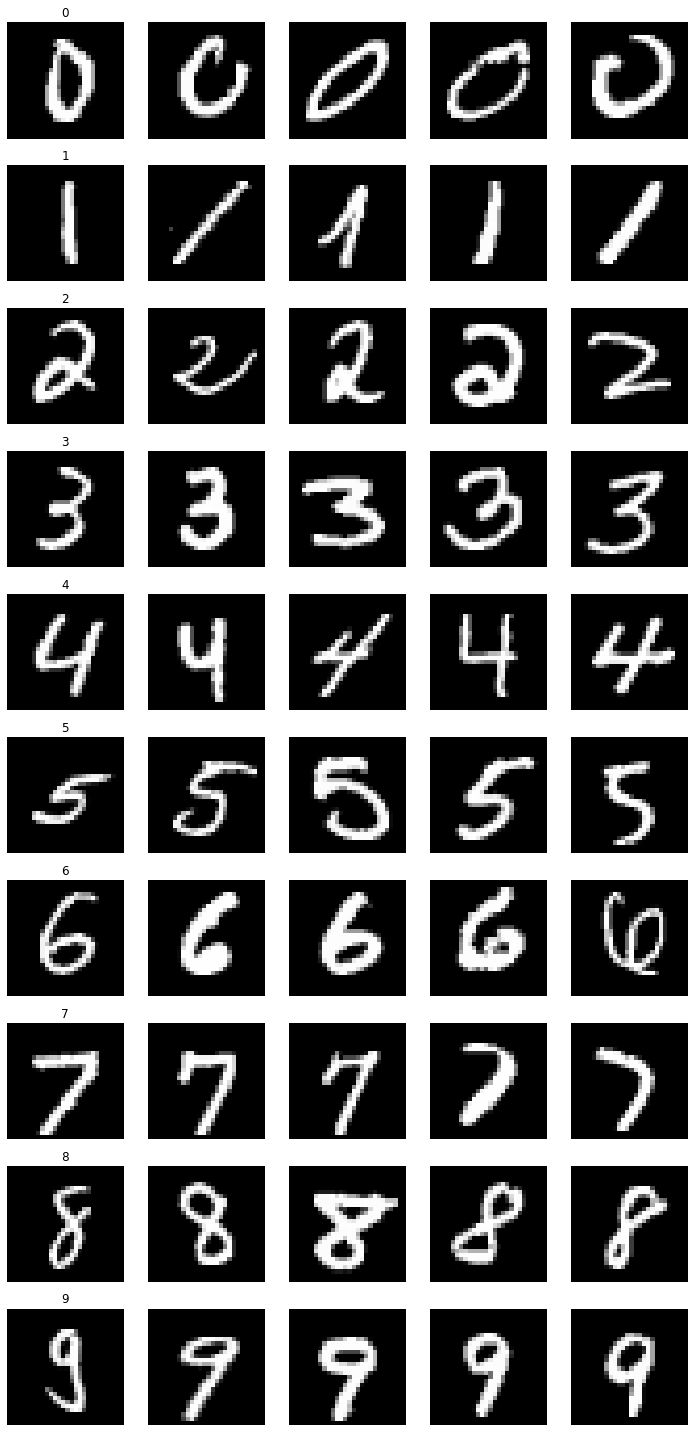

In [47]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
fig, axs = plt.subplots(10, 5, figsize=(10, 20))
for i in range(10):
    class_samples = np.random.choice(np.where(train_dataset.dataset.targets == i)[0], size=5, replace=False)
    for j, sample_idx in enumerate(class_samples):
        axs[i, j].imshow(train_dataset.dataset.data[sample_idx], cmap='gray')
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(class_names[i])
plt.tight_layout()
plt.show()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

### Part 3

In [58]:
class MLP(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = MLP(784,256,10)

print(f'The number of trainable parameters is {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

The number of trainable parameters is 269,322


### Part 4

In [93]:
def run_epochs(num_epochs,criterion,optimizer,model):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  for epoch in range(num_epochs):   ## Running for 5 epochs
      
      model.train()
      train_loss = 0.0
      train_correct = 0
      for inputs, targets in train_loader:
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()

          train_loss += loss.item() * inputs.size(0)
          train_correct += torch.sum(torch.argmax(outputs, dim=1) == targets)

      train_loss /= len(train_loader.dataset)
      train_acc = train_correct / len(train_loader.dataset)
      train_losses.append(train_loss)
      train_accs.append(train_acc)

      model.eval()
      val_loss = 0.0
      val_correct = 0
      with torch.no_grad():
          for inputs, targets in val_loader:
              outputs = model(inputs)
              loss = criterion(outputs, targets)

              val_loss += loss.item() * inputs.size(0)
              val_correct += torch.sum(torch.argmax(outputs, dim=1) == targets)

      val_loss /= len(val_loader.dataset)
      val_acc = val_correct / len(val_loader.dataset)
      val_losses.append(val_loss)
      val_accs.append(val_acc)


      if val_acc > best_acc:
          best_acc = val_acc
          best_model_wts = copy.deepcopy(model.state_dict())

    
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, '
            f'Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


  model.load_state_dict(best_model_wts)
  print('Best Val Acc: {:.4f}'.format(best_acc))
  return train_losses,train_accs,val_losses,val_accs

num_epochs = 5

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses,train_accs,val_losses,val_accs  = run_epochs(num_epochs,criterion,optimizer,model)

Epoch 1/5, Train Loss: 0.0730, Train Acc: 0.9772, Val Loss: 0.0809, Val Acc: 0.9758
Epoch 2/5, Train Loss: 0.0734, Train Acc: 0.9768, Val Loss: 0.0806, Val Acc: 0.9766
Epoch 3/5, Train Loss: 0.0704, Train Acc: 0.9779, Val Loss: 0.0996, Val Acc: 0.9688
Epoch 4/5, Train Loss: 0.0662, Train Acc: 0.9791, Val Loss: 0.0816, Val Acc: 0.9761
Epoch 5/5, Train Loss: 0.0648, Train Acc: 0.9797, Val Loss: 0.0688, Val Acc: 0.9793
Best Val Acc: 0.9793


### Part 5


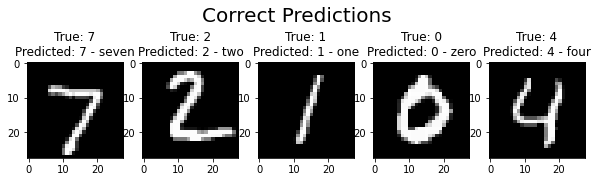

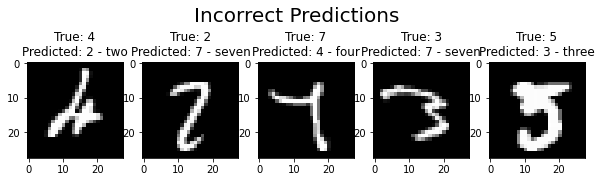

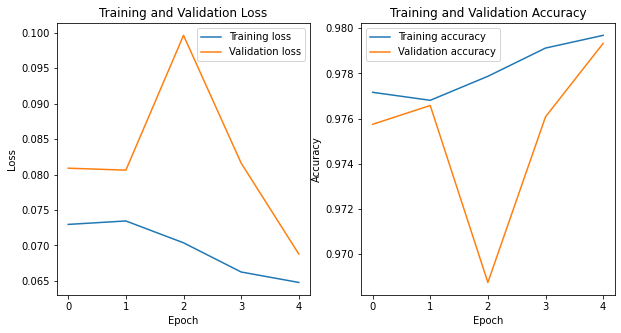

In [94]:
model.eval()
test_preds = []
test_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

correct_indices = []
incorrect_indices = []
for i in range(len(test_dataset)):
    if test_preds[i] == test_targets[i]:
        if len(correct_indices) < 5:
            correct_indices.append(i)
    else:
        if len(incorrect_indices) < 5:
            incorrect_indices.append(i)
    if len(correct_indices) == 5 and len(incorrect_indices) == 5:
        break


fig, axs = plt.subplots(1, 5, figsize=(10, 3))
for i, idx in enumerate(correct_indices):
    img, true_label = test_dataset[idx]
    pred_label = test_dataset.classes[test_preds[idx]]
    axs[i].imshow(img.squeeze().numpy(), cmap='gray')
    axs[i].set(title=f"True: {true_label}\nPredicted: {pred_label}")
plt.suptitle("Correct Predictions", fontsize=20)
plt.show()


fig, axs = plt.subplots(1, 5, figsize=(10, 3))
for i, idx in enumerate(incorrect_indices):
    img, true_label = test_dataset[idx]
    pred_label = test_dataset.classes[test_preds[idx]]
    axs[i].imshow(img.squeeze().numpy(), cmap='gray')
    axs[i].set(title=f"True: {true_label}\nPredicted: {pred_label}")
plt.suptitle("Incorrect Predictions", fontsize=20)
plt.show()


plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(1,2,1),
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2),
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
